In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from joblib import dump, load
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
param_sets = [
    {
        'n_neighbors': 5
    }
]

# Đọc dữ liệu train
train_data = pd.read_csv('R2G_output/undersampled_train.csv')
X_train = train_data.drop('Label', axis=1)
y_train = train_data['Label']

# Khởi tạo KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá
all_cv_metrics = []
for i, params in enumerate(param_sets, 1):
    print(f"Đang đánh giá (Param Set {i})...")
    fold_metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = KNeighborsClassifier(**params)
        
        # Train và đo thời gian
        start_time = time.time()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        end_time = time.time()
        
        # Tính metrics (không bao gồm model size)
        metrics = [
            accuracy_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            f1_score(y_val, y_pred),
            roc_auc_score(y_val, y_pred),
            end_time - start_time
        ]
        
        # Tính model size riêng
        temp_path = f'temp_model_fold_{i}.joblib'
        dump(model, temp_path)
        model_size = os.path.getsize(temp_path) / 1024
        os.remove(temp_path)
        
        # Thêm model size vào metrics
        metrics.append(model_size)
        fold_metrics.append(metrics)
    
    avg_metrics = np.mean(fold_metrics, axis=0)
    all_cv_metrics.append(avg_metrics)
    print(f"Kết quả CV - Accuracy: {avg_metrics[0]:.4f}, AUC: {avg_metrics[4]:.4f}")

metrics_cv1 = all_cv_metrics[0] 

Đang đánh giá (Param Set 1)...
Kết quả CV - Accuracy: 0.9686, AUC: 0.9569


In [3]:
# Đọc dữ liệu test
test_data = pd.read_csv('R2G_output/undersampled_test.csv')
X_test = test_data.drop('Label', axis=1)
y_test = test_data['Label']

# Đánh giá từng bộ tham số
all_test_metrics = []
for i, params in enumerate(param_sets, 1):
    print(f"Đang đánh giá Param Set {i} trên test set...")
    model = KNeighborsClassifier(**params)
    
    # Train và đo thời gian
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    # Tính metrics (không bao gồm model size)
    metrics = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred),
        end_time - start_time
    ]
    
    # Tính model size riêng và lưu model
    model_path = f'knn_model_undersampled{i}.joblib'
    dump(model, model_path)
    model_size = os.path.getsize(model_path) / 1024
    
    # Thêm model size vào metrics
    metrics.append(model_size)
    all_test_metrics.append(metrics)
    print(f"Param Set {i} - Test Metrics:", metrics)
    
metrics_test1 = all_test_metrics[0] 

Đang đánh giá Param Set 1 trên test set...
Param Set 1 - Test Metrics: [0.9685370066347708, 0.9835916355200413, 0.9209749254249177, 0.9512539511585196, np.float64(0.9566465087529954), 235.60651087760925, 830323.443359375]


In [4]:
# Tạo báo cáo Excel đơn giản
report_df = pd.DataFrame({
    'Dataset': ['CV', 'Test'],
    'Accuracy (%)': [all_cv_metrics[0][0]*100, all_test_metrics[0][0]*100],
    'Precision (%)': [all_cv_metrics[0][1]*100, all_test_metrics[0][1]*100],
    'Recall (%)': [all_cv_metrics[0][2]*100, all_test_metrics[0][2]*100],
    'F1 (%)': [all_cv_metrics[0][3]*100, all_test_metrics[0][3]*100],
    'AUC (%)': [all_cv_metrics[0][4]*100, all_test_metrics[0][4]*100],
    'Exec Time (s)': [all_cv_metrics[0][5], all_test_metrics[0][5]],
    'Model Size (KB)': [int(all_cv_metrics[0][6]), int(all_test_metrics[0][6])]
})
report_df.to_excel('knn_undersampled_report.xlsx', index=False)

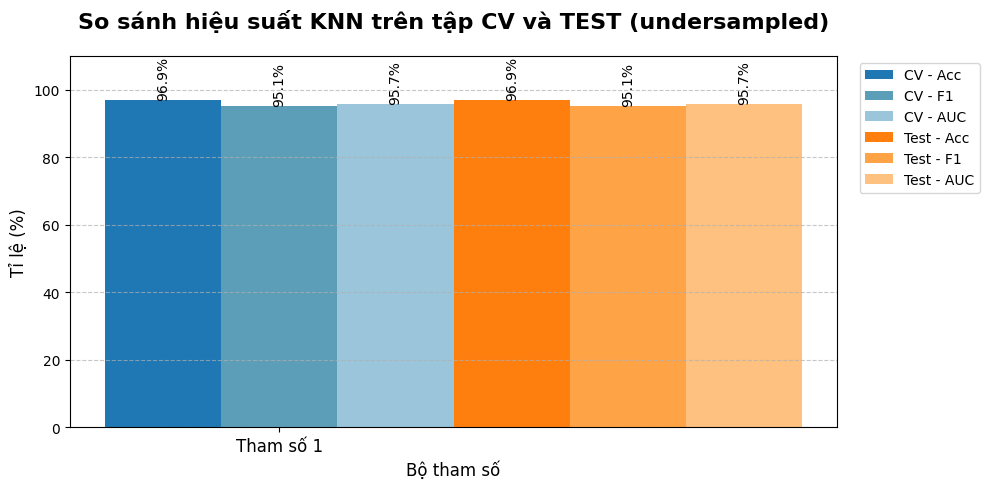

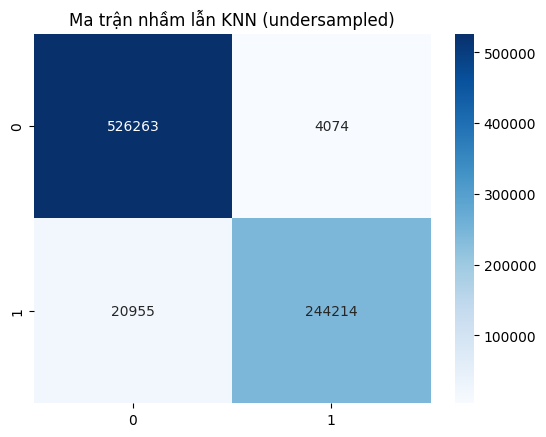

In [5]:
# 1. Vẽ biểu đồ so sánh CV vs Test
labels = ['Acc', 'F1', 'AUC'] * 2  # Nhãn cho 6 cột
colors = ['#1f77b4', '#5c9eb7', '#9ac5db', '#ff7f0e', '#ffa347', '#ffc17f']  # Xanh nhạt dần -> cam nhạt dần

# Tạo mảng giá trị cho từng param set
data = []
for i in range(len(param_sets)):
    # Thêm 3 giá trị CV (acc, f1, auc)
    data.extend([all_cv_metrics[i][0]*100, all_cv_metrics[i][3]*100, all_cv_metrics[i][4]*100])
    # Thêm 3 giá trị Test (acc, f1, auc)
    data.extend([all_test_metrics[i][0]*100, all_test_metrics[i][3]*100, all_test_metrics[i][4]*100])

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
x = np.arange(len(param_sets))  
width = 0.10  

# Vẽ từng cột
bars = []
for i in range(6): 
    bar_pos = x + (i * width) - (1 * width)  
    bars.append(plt.bar(bar_pos, 
                       [data[j*6 + i] for j in range(len(param_sets))], 
                       width, 
                       color=colors[i]))

# Cấu hình trục và nhãn
plt.title('So sánh hiệu suất KNN trên tập CV và TEST (undersampled)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Bộ tham số', fontsize=12)
plt.ylabel('Tỉ lệ (%)', fontsize=12)
plt.xticks(x, [f'Tham số {i+1}' for i in range(len(param_sets))], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm chú thích
legend_labels = ['CV - Acc', 'CV - F1', 'CV - AUC', 'Test - Acc', 'Test - F1', 'Test - AUC']
plt.legend(bars, legend_labels, fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')

# Thêm giá trị trên mỗi cột (xoay dọc)
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', rotation=90, fontsize=10)

plt.tight_layout()
plt.ylim(0, 110)
plt.show()

# 2. Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn KNN (undersampled)')
plt.show()